In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/AffectNet/"
TOP_EMOTIONS = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

TRAIN_SIZE = 0.80
INPUT_SHAPE = (64,64,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

surprise has 1851 number of images
fear has 1839 number of images
neutral has 1880 number of images
sad has 1821 number of images
disgust has 1740 number of images
contempt has 1833 number of images
happy has 1862 number of images
anger has 1822 number of images

total images are 14648


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            img = cv2.resize(img, (64, 64))  # Resize the image to (64, 64)
            img_arr.append(np.expand_dims(img, axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1,1))

img_arr.shape, img_label.shape, label_to_text

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded contempt images to numpy arrays...
loaded happy images to numpy arrays...
loaded anger images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((14648, 64, 64, 1),
 (14648, 8),
 {0: 'surprise',
  1: 'fear',
  2: 'neutral',
  3: 'sad',
  4: 'disgust',
  5: 'contempt',
  6: 'happy',
  7: 'anger'})

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
def inception_block(X,
                    filters_1x1: int,
                    filters_3x3_reduce: int,
                    filters_3x3: int,
                    filters_5x5_reduce: int,
                    filters_5x5: int,
                    filters_pool_proj: int,
                    block_name: str):

    conv_1x1 = Conv2D(
            filters=filters_1x1,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_1x1",
        )(X)

    conv_3x3_reduce = Conv2D(
            filters=filters_3x3_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3_reduce",
        )(X)
    conv_3x3 = Conv2D(
            filters=filters_3x3,
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3",
        )(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(
            filters=filters_5x5_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5_reduce",
        )(X)
    conv_5x5 = Conv2D(
            filters=filters_5x5,
            kernel_size=(5,5),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5",
        )(conv_5x5_reduce)

    pool_proj = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name=f"incepblock{block_name}_maxpool",
    )(X)
    conv_after_pool = Conv2D(
            filters=filters_pool_proj,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_afterpool",
        )(pool_proj)

    concated = concatenate([conv_1x1, conv_3x3, conv_5x5, conv_after_pool], axis=3, name=f"incepblock{block_name}_concat")
    return concated

In [ ]:
def auxiliary_block(X, out_shape: int, block_id: int):
    X = AveragePooling2D(
        pool_size=(3,3),
        strides=(1,1),
        padding='valid',
        name=f"auxblock{block_id}_avgpool",
    )(X)

    X = Conv2D(
            filters=128,
            kernel_size=(1,1),
            strides=(1,1),
            padding='same',
            activation='relu',
            name=f"auxblock{block_id}_conv2d",
    )(X)

    X = Flatten(name=f"auxblock{block_id}_flatten",)(X)

    X = Dense(units=128, activation='relu', name=f"auxblock{block_id}_dense1",)(X)

    X = Dropout(0.25, name=f"auxblock{block_id}_dropout",)(X)

    X = Dense(units=out_shape, activation='softmax', name=f"auxblock{block_id}_outlayer",)(X)
    return X

In [ ]:
def InceptionNet(in_shape, out_shape, show_summary=False):
    "shallow inception-net without auxiliary layers"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(model_in)
    X = Conv2D(
            filters=64,
            kernel_size=(1,1),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(X)

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(X,
            filters_1x1=64,
            filters_3x3_reduce=96,
            filters_3x3=128,
            filters_5x5_reduce=16,
            filters_5x5=32,
            filters_pool_proj=32,
            block_name='1a'
    )
    X = inception_block(X,
            filters_1x1=128,
            filters_3x3_reduce=128,
            filters_3x3=192,
            filters_5x5_reduce=32,
            filters_5x5=96,
            filters_pool_proj=64,
            block_name='1b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=192,
        filters_3x3_reduce=96,
        filters_3x3=208,
        filters_5x5_reduce=16,
        filters_5x5=48,
        filters_pool_proj=64,
        block_name='2a'
    )
    X = inception_block(
        X,
        filters_1x1=160,
        filters_3x3_reduce=112,
        filters_3x3=224,
        filters_5x5_reduce=24,
        filters_5x5=64,
        filters_pool_proj=64,
        block_name='2b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=256,
        filters_3x3_reduce=160,
        filters_3x3=320,
        filters_5x5_reduce=32,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3a'
    )
    X = inception_block(
        X,
        filters_1x1=384,
        filters_3x3_reduce=192,
        filters_3x3=384,
        filters_5x5_reduce=48,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3b'
    )

    X = GlobalAveragePooling2D()(X)

    X = Dense(128, activation='relu')(X)
    X = Dropout(0.25)(X)

    model_out = Dense(out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="InceptionNet")

    if show_summary:
        model.summary()

    return model

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

Model: "InceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_layer            │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ in_layer[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      6,240 │ max_pooling2d[0]… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      1,040 │ max_pooling2d[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_maxpo… │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │    110,720 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │     12,832 │ incepblock1a_con… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      2,080 │ incepblock1a_max… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_concat │ (None, 32, 32,    │          0 │ incepblock1a_con… │
│ (Concatenate)       │ 256)              │            │ incepblock1a_con… │
│                     │                   │            │ incepblock1a_con… │
│                     │                   │            │ incepblock1a_con… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │     32,896 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │      8,224 │ incepblock1a_con… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_maxpo… │ (None, 32, 32,    │          0 │ incepblock1a_con… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │     32,896 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                 

 Total params: 3,789,024 (14.45 MB)

 Trainable params: 3,789,024 (14.45 MB)

 Non-trainable params: 0 (0.00 B)

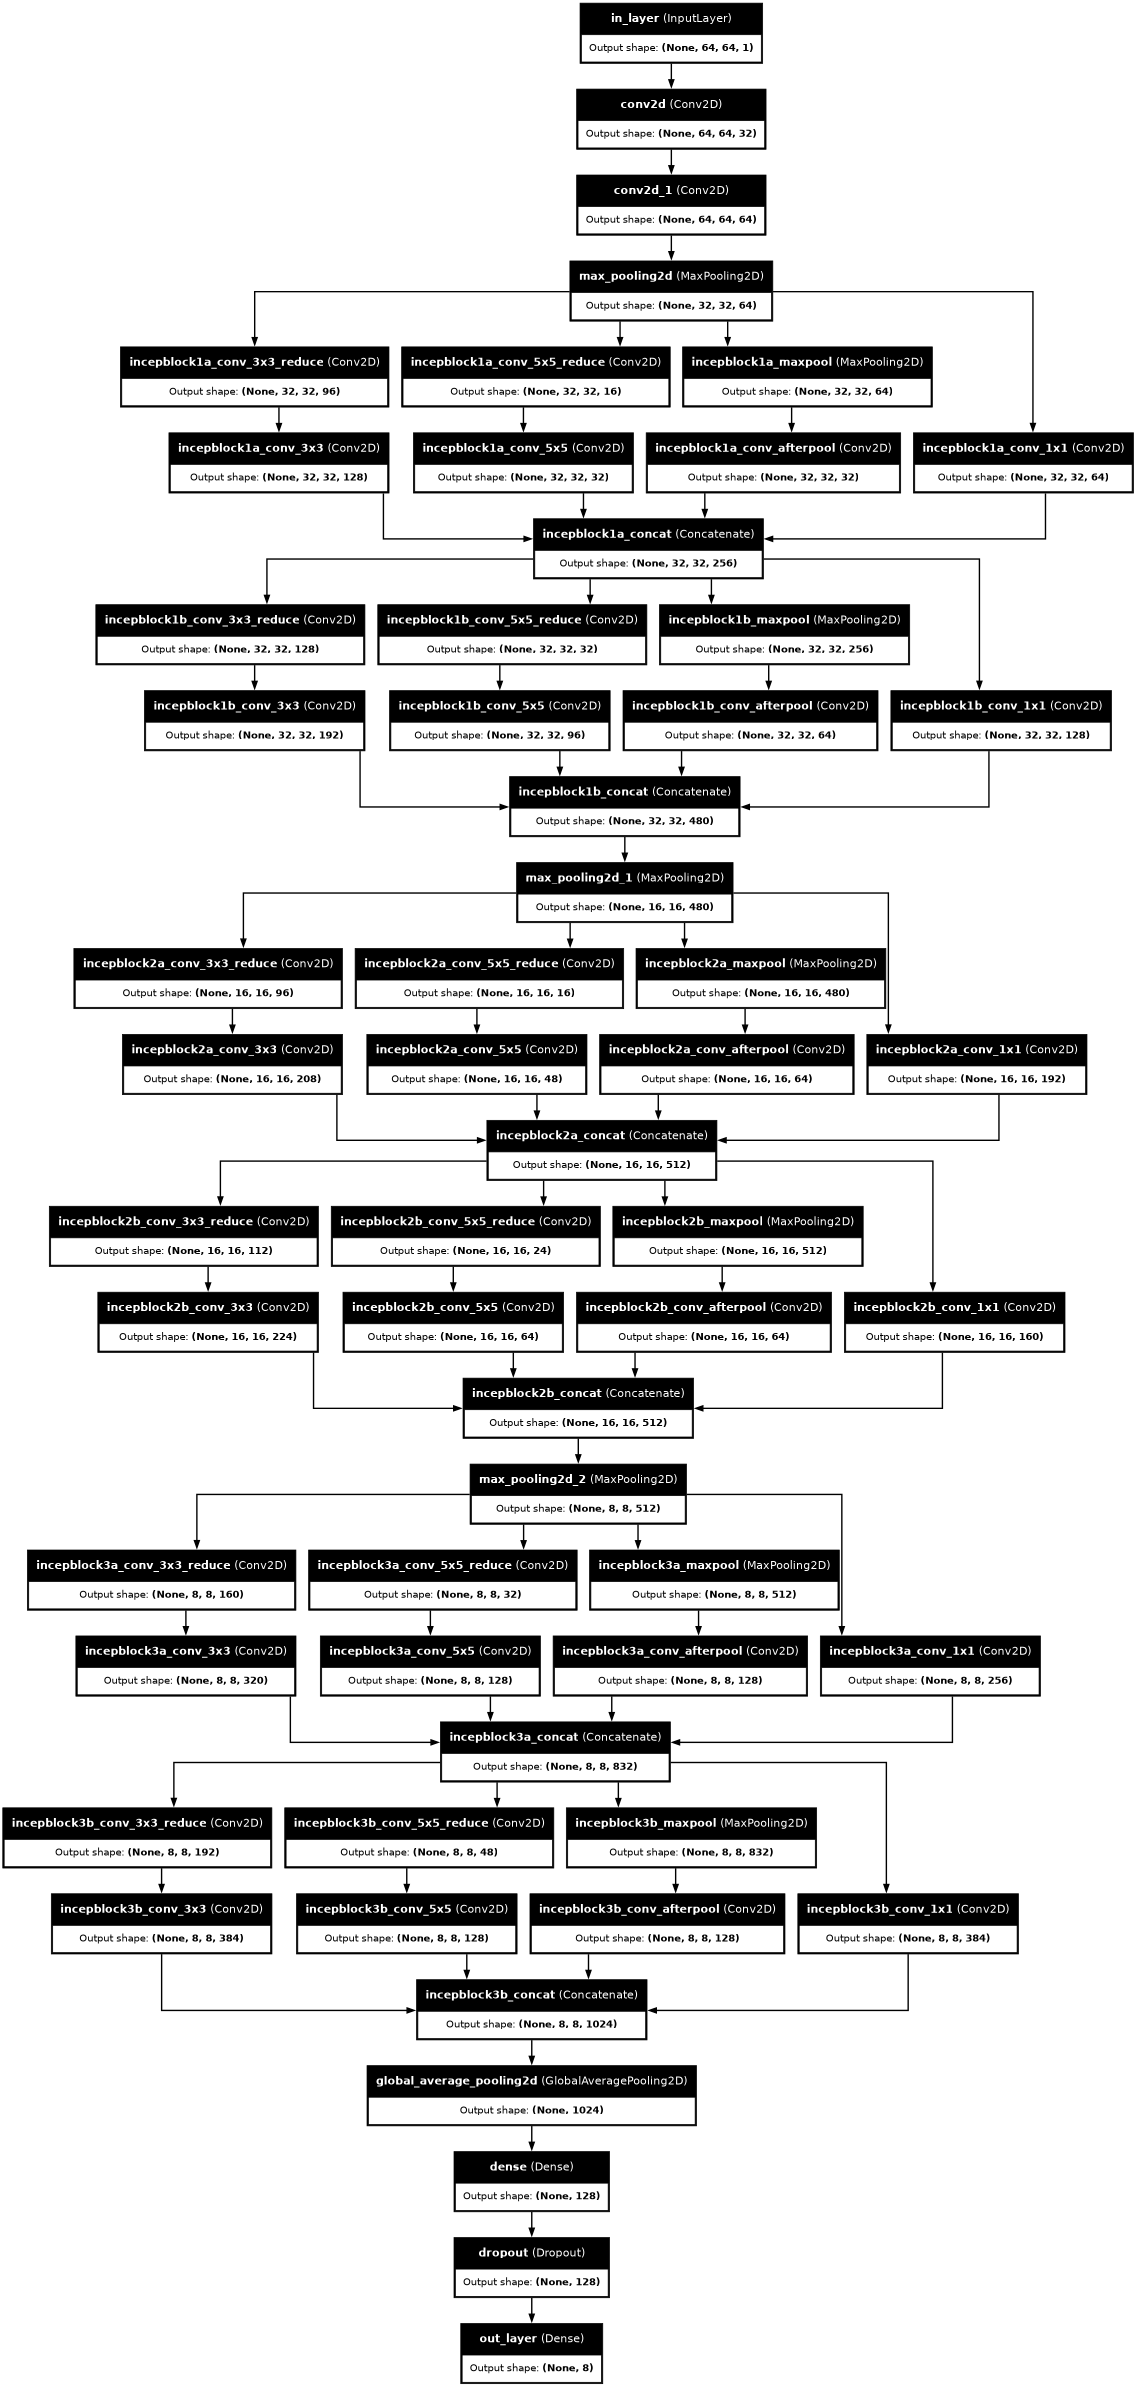

In [ ]:
model = InceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=13,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 100

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

train_datagen.fit(X_train)

custom_early_stopping = CustomEarlyStopping(patience=15)

history_InceptionNet = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs = epochs,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/366 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.0703 - loss: 3.4843   

I0000 00:00:1711358898.823472     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711358898.870005     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/366 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.1283 - loss: 2.2353

W0000 00:00:1711358928.355863     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1287 - loss: 2.1739

W0000 00:00:1711358939.404913     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 86s 132ms/step - accuracy: 0.1287 - loss: 2.1737 - val_accuracy: 0.1249 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 2/100
  1/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.0312 - loss: 2.0803

W0000 00:00:1711358947.089546     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0312 - loss: 2.0803 - val_accuracy: 0.1259 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 3/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.1319 - loss: 2.0798 - val_accuracy: 0.1198 - val_loss: 2.0806 - learning_rate: 0.0010
Epoch 4/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1562 - loss: 2.0850 - val_accuracy: 0.1263 - val_loss: 2.0796 - learning_rate: 0.0010
Epoch 5/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1263 - loss: 2.0798
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.1263 - loss: 2.0798 - val_accuracy: 0.1273 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 6/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0312 - loss: 2.0789 - val_accuracy: 0.1273 - val_loss: 2.0791 - learning_rate: 1.0000e-04
Epoch 7/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.1279 - loss: 2.07

In [ ]:
history = pd.DataFrame(history_InceptionNet.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.125877,2.097658,0.124915,2.079110,1.000000e-03
1,0.031250,2.080325,0.125939,2.079097,1.000000e-03
2,0.128958,2.080015,0.119795,2.080591,1.000000e-03
3,0.156250,2.085016,0.126280,2.079562,1.000000e-03
4,0.122369,2.079749,0.127304,2.079090,1.000000e-03
...,...,...,...,...,...
76,0.478008,1.335953,0.459727,1.364974,1.000000e-07
77,0.406250,1.364415,0.459727,1.364975,1.000000e-07
78,0.477409,1.332643,0.460068,1.364794,1.000000e-07
79,0.531250,1.062118,0.460068,1.364790,1.000000e-07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

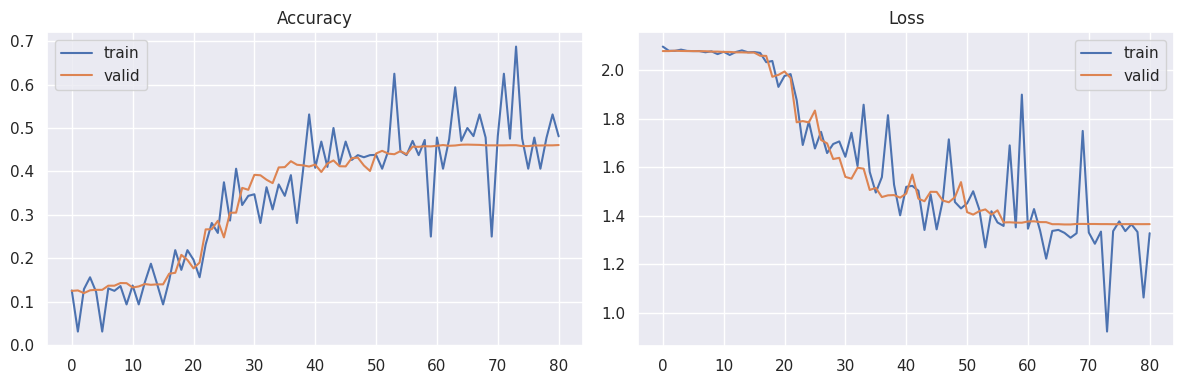

In [ ]:
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['accuracy'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['loss'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

In [ ]:
label_to_text

{0: 'surprise',
 1: 'fear',
 2: 'neutral',
 3: 'sad',
 4: 'disgust',
 5: 'contempt',
 6: 'happy',
 7: 'anger'}

367/367 - 7s - 20ms/step - accuracy: 0.4866 - loss: 1.3060


W0000 00:00:1711359927.237724     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.4866017997264862
92/92 - 1s - 16ms/step - accuracy: 0.4618 - loss: 1.3646

Test Accuracy: 0.4617747366428375
10/92 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

W0000 00:00:1711359931.324378     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


W0000 00:00:1711359934.642813     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       anger       0.42      0.26      0.32       370
    contempt       0.33      0.48      0.39       368
     disgust       0.75      0.77      0.76       376
        fear       0.22      0.07      0.11       364
       happy       0.30      0.11      0.16       348
     neutral       0.40      0.62      0.48       367
         sad       0.82      0.90      0.86       373
    surprise       0.30      0.45      0.36       364

    accuracy                           0.46      2930
   macro avg       0.44      0.46      0.43      2930
weighted avg       0.44      0.46      0.43      2930



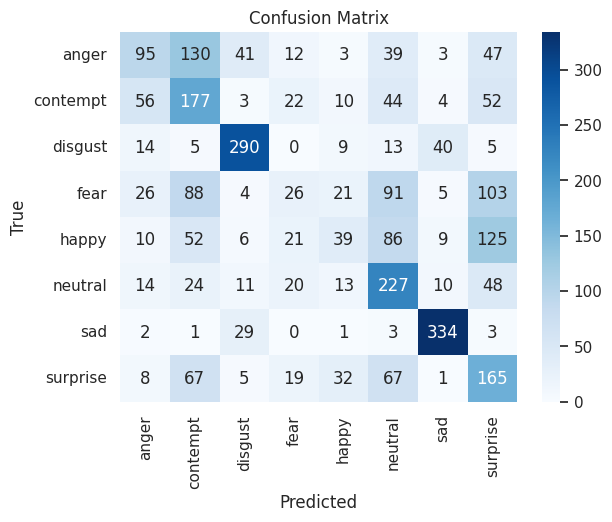

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

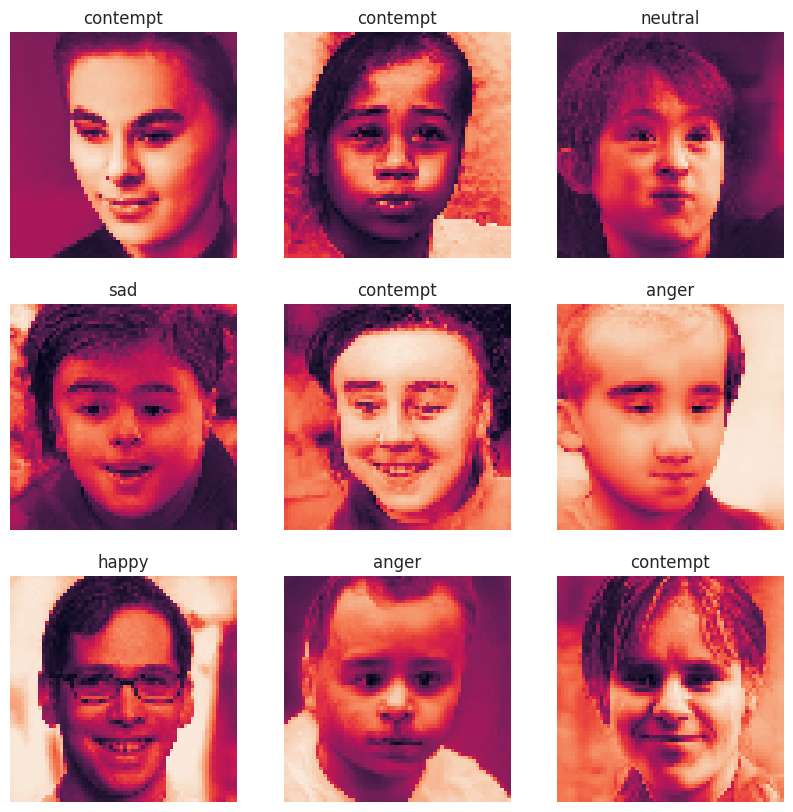

In [ ]:
# Visualize some predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(label_to_text[predicted_labels[i]])
    plt.axis("off")

plt.show()